In [1]:
#!pip install squarify
# !pip install seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import squarify
import ast
import os
import seaborn as sns
from matplotlib import colors

### 1. 평균 러닝타임과 인기도 관계

In [43]:
# 1. 데이터 로드
track_df = pd.read_csv('./data/tracks.csv')
track_df['release_date'] = pd.to_datetime(track_df['release_date'], errors='coerce')
track_df['year'] = track_df['release_date'].dt.year

track_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                586672 non-null  object        
 1   name              586601 non-null  object        
 2   popularity        586672 non-null  int64         
 3   duration_ms       586672 non-null  int64         
 4   explicit          586672 non-null  int64         
 5   artists           586672 non-null  object        
 6   id_artists        586672 non-null  object        
 7   release_date      586672 non-null  datetime64[ns]
 8   danceability      586672 non-null  float64       
 9   energy            586672 non-null  float64       
 10  key               586672 non-null  int64         
 11  loudness          586672 non-null  float64       
 12  mode              586672 non-null  int64         
 13  speechiness       586672 non-null  float64       
 14  acou

In [4]:
# 2. 분석할 연도 필터링
years = [1980, 1990, 2000, 2010, 2020]
df_filtered = track_df[track_df['year'].isin(years)]


In [5]:
# 3. 연도별 평균 러닝타임, 인기도 계산
stats = (
    df_filtered
    .groupby('year')[['duration_ms', 'popularity']]
    .mean()
    .reset_index()
)

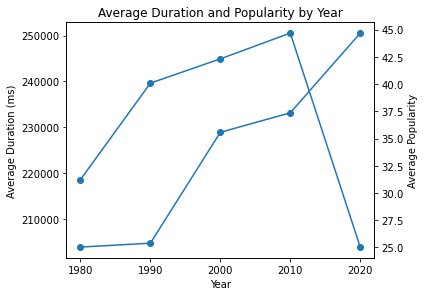

In [6]:
# 4. 이중 축 그래프 그리기
fig, ax1 = plt.subplots()

# 왼쪽 축: duration_ms
ax1.plot(stats['year'], stats['duration_ms'], marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Duration (ms)')
ax1.set_xticks(years)

# 오른쪽 축: popularity
ax2 = ax1.twinx()
ax2.plot(stats['year'], stats['popularity'], marker='o')
ax2.set_ylabel('Average Popularity')

fig.tight_layout()
plt.title('Average Duration and Popularity by Year')
plt.show()

------------------------

### 2. 장르별 평균 러닝타임

In [7]:
# 1. 데이터 로드 & 1980~2020 필터링
artists = pd.read_csv('./data/artists.csv')

track_df['release_date'] = pd.to_datetime(track_df['release_date'], errors='coerce')
track_df['year'] = track_df['release_date'].dt.year
df = track_df[(track_df['year'] >= 1980) & (track_df['year'] <= 2020)].copy()

In [8]:
# 2. primary_artist 추출
def get_first_artist(x):
    if pd.isna(x): return None
    try:
        lst = ast.literal_eval(x)
        return lst[0] if isinstance(lst, list) and lst else None
    except:
        return x

df['primary_artist'] = df['artists'].apply(get_first_artist)

In [9]:
# 3. 아티스트 테이블에서 primary_genre 생성
artists['genres_list'] = artists['genres'].apply(
    lambda x: ast.literal_eval(x) if pd.notna(x) else []
)
artists['primary_genre'] = artists['genres_list'].apply(
    lambda lst: lst[0] if lst else None
)


In [10]:
# 4. tracks ↔ artists 조인
df = df.merge(
    artists[['name','primary_genre']],
    left_on='primary_artist',
    right_on='name',
    how='left'
)

In [11]:
# 5. Broad Category 매핑 함수 정의
def map_category(genre):
    if not isinstance(genre, str):
        return None
    g = genre.lower()
    if 'hip hop' in g or 'rap' in g:
        return 'Rap/Hip‑Hop'
    elif 'jazz' in g:
        return 'Jazz'
    elif 'r&b' in g or 'rnb' in g:
        return 'R&B'
    elif 'pop' in g:
        return 'Pop'
    elif 'rock' in g:
        return 'Rock'
    elif any(k in g for k in ['electro','edm','house','dance','techno','electronic']):
        return 'Electronic'
    elif 'classical' in g:
        return 'Classical'
    else:
        return None

In [12]:
# 6. 각 트랙에 Broad Category 할당
df['broad_category'] = df['primary_genre'].apply(map_category)

In [13]:
# 7. 원하는 카테고리만 필터링
categories = ['Rap/Hip‑Hop','Jazz','R&B','Pop','Rock','Electronic','Classical']
df_sel = df[df['broad_category'].isin(categories)].copy()

In [ ]:
# 8. 카테고리별 트랙 수 및 평균 러닝타임 집계
counts = df_sel['broad_category'].value_counts().loc[categories]
avg_ms = df.groupby('broad_category')['duration_ms'].mean()
sizes  = counts.values
labels = []

for genre in counts.index:
    msec = avg_ms.loc[genre]
    total_sec = int(msec // 1000)
    m = total_sec // 60
    s = total_sec % 60
    labels.append(f'{genre}\n{m:02d}:{s:02d}')

In [21]:
# 9. 녹→빨 그라데이션 컬러 매핑
norm      = colors.Normalize(vmin=sizes.min(), vmax=sizes.max())
cmap      = colors.LinearSegmentedColormap.from_list('GreenRed', ['green','red'])
color_vals = [cmap(norm(v)) for v in sizes]

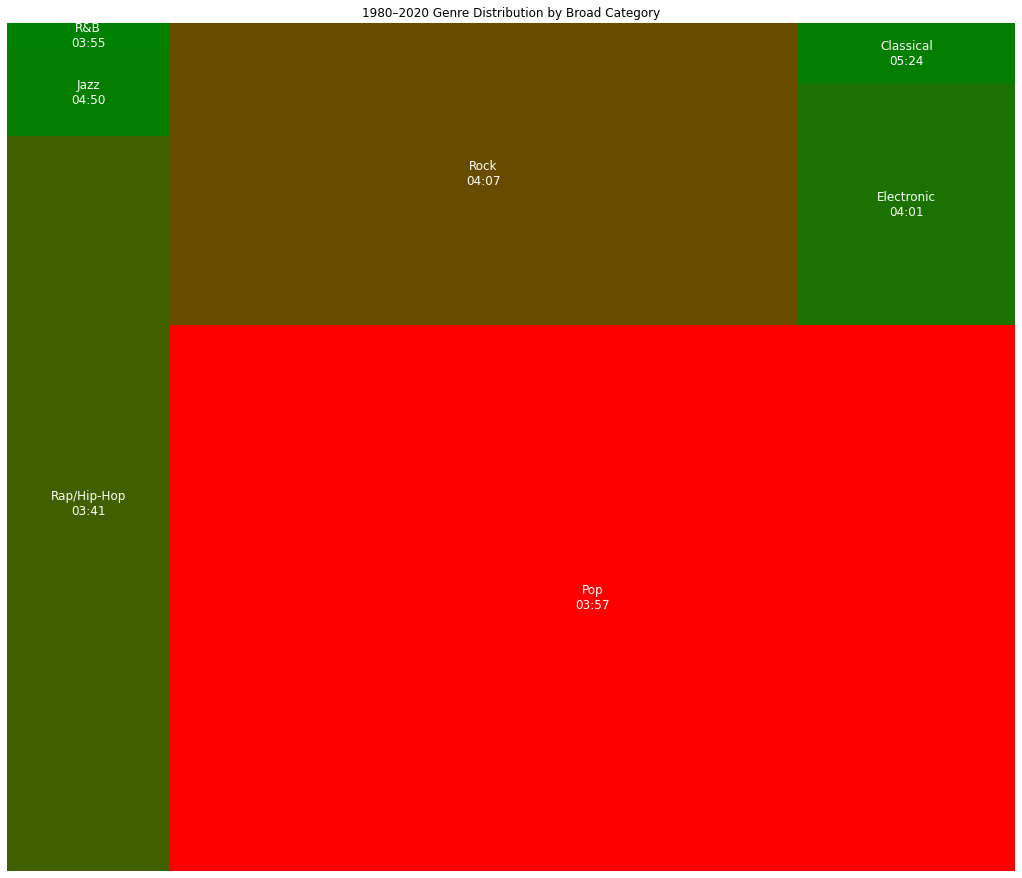

In [27]:

# 10. 트리맵 그리기
plt.figure(figsize=(14, 12))
squarify.plot(
    sizes=sizes,
    label=labels,
    color=color_vals,
    pad=False,                 # 박스 사이 공백 제거
    bar_kwargs={'linewidth':0},
    text_kwargs={'fontsize':12, 'color':'white'}
)
plt.title('1980–2020 Genre Distribution by Broad Category')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

----------------

### 10년 단위 boxplot

In [38]:
df['decade'] = (df['year'] // 10) * 10
df['runtime_min'] = df['duration_ms'] / 60000

decade_bins = [1980, 1990, 2000, 2010, 2020]
data = []
labels = []
for dec in decade_bins:
    runtimes = df.loc[df['decade'] == dec, 'runtime_min']
    if not runtimes.empty:
        data.append(runtimes)
        labels.append(f"{dec}s")

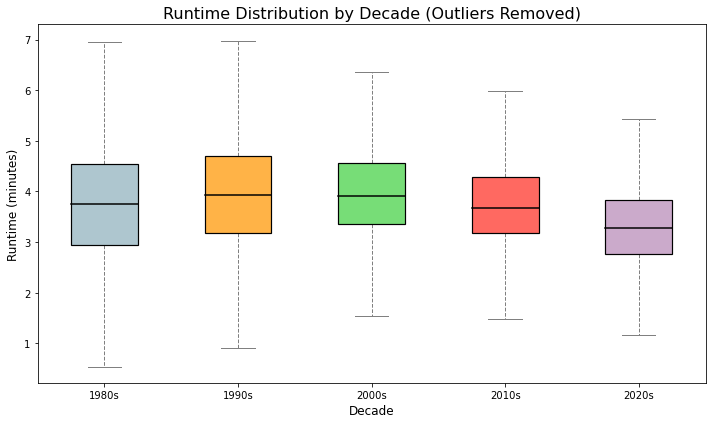

In [41]:
colors = ['#AEC6CF', '#FFB347', '#77DD77', '#FF6961', '#CBAACB']

fig, ax = plt.subplots(figsize=(10, 6))
bp = ax.boxplot(
    data,
    labels=labels,
    patch_artist=True,
    showfliers=False
)

# 여기서 바로 컬러 변경
for box, color in zip(bp['boxes'], colors):
    box.set(facecolor=color, edgecolor='black', linewidth=1.2)

# (선택) 중앙선, 수염, 캡 스타일도 바꿔보기
for median in bp['medians']:
    median.set(color='black', linewidth=1.5)
for whisker in bp['whiskers']:
    whisker.set(color='gray', linestyle='--', linewidth=1)
for cap in bp['caps']:
    cap.set(color='gray', linewidth=1)

ax.set_title('Runtime Distribution by Decade (Outliers Removed)', fontsize=16)
ax.set_xlabel('Decade', fontsize=12)
ax.set_ylabel('Runtime (minutes)', fontsize=12)

plt.tight_layout()
plt.show()